# Predicting Customer Churn - Telco 

In [4]:
!pip install seaborn
!pip install seldon_deploy_sdk

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached seldon_deploy_sdk-1.5.0-py3-none-any.whl (807 kB)
  Using cached Authlib-0.15.5-py2.py3-none-any.whl (203 kB)


In [34]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, ModelMetadataServiceApi, DriftDetectorApi, BatchJobsApi, BatchJobDefinition
from seldon_deploy_sdk.auth import OIDCAuthenticator

from alibi.explainers import AnchorTabular

In [2]:
!gsutil cp gs://kelly-seldon/customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv WA_Fn-UseC_-Telco-Customer-Churn.csv

Copying gs://kelly-seldon/customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv...
/ [1 files][954.6 KiB/954.6 KiB]                                                
Operation completed over 1 objects/954.6 KiB.                                    


In [3]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


The dataset consists of the following columns:

* customerID

Services that a customer has signed up for:

* PhoneService
* MultipleLines
* InternetService
* OnlineSecurity
* OnlineBackup
* DeviceProtection
* TechSupport
* StreamingTV
* StreamingMovies

Customer account information:

* tenure - how long they've been a customer
* Contract 
* PaymentMethod
* PaperlessBilling
* MonthlyCharges
* TotalCharges

Demographic information about a customer:

* gender
* SeniorCitizen
* Partner
* Dependents

Label:

* Churn - customer who left within the last month

In [4]:
df.value_counts("Churn")

Churn
No     5174
Yes    1869
dtype: int64

In [5]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
print(rows_with_NaN.head(), "\n\n", "Number of rows with missing values:", len(rows_with_NaN))

Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []

[0 rows x 21 columns] 

 Number of rows with missing values: 0


In [6]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
df.drop("customerID", axis=1, inplace=True)

In [8]:
df = df[df["TotalCharges"] != " "]
df["TotalCharges"] = df["TotalCharges"].astype(float)

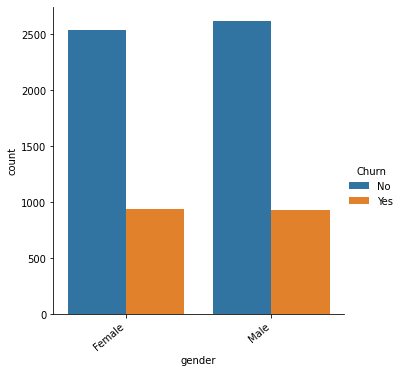

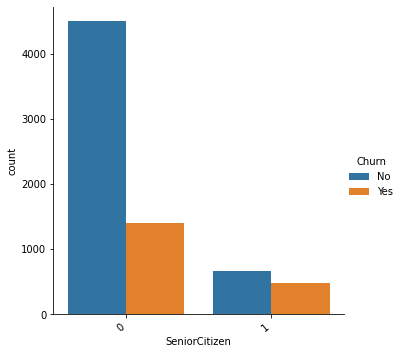

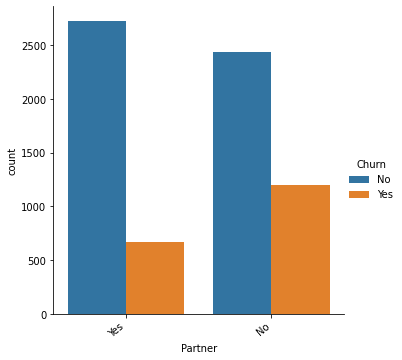

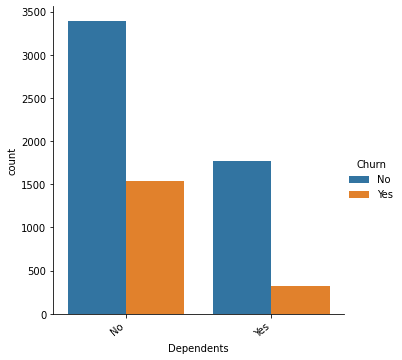

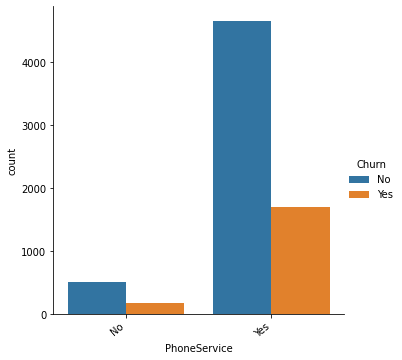

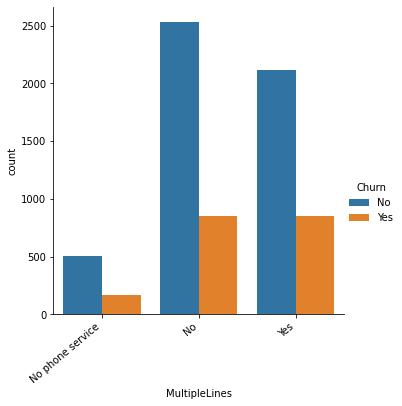

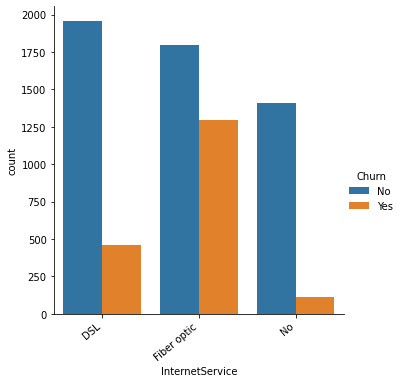

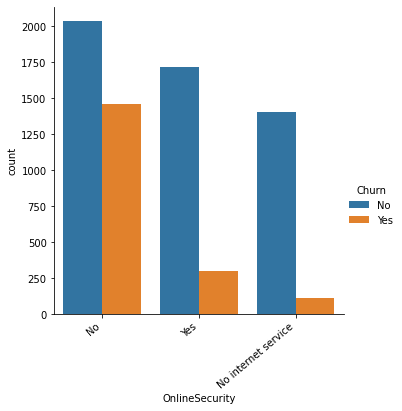

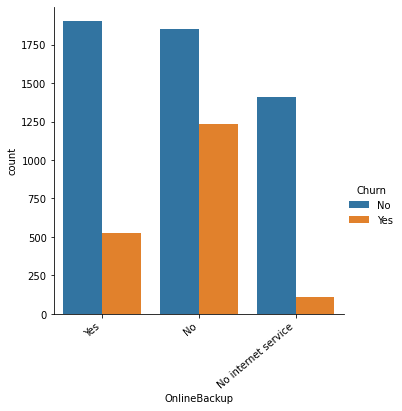

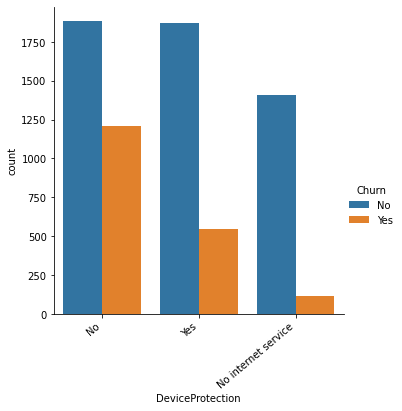

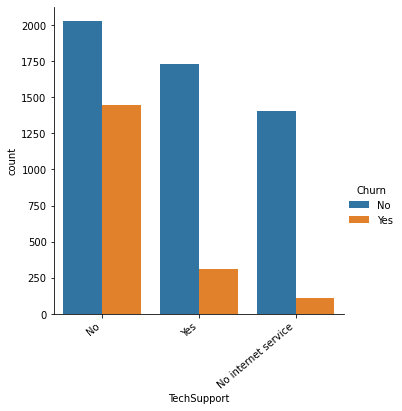

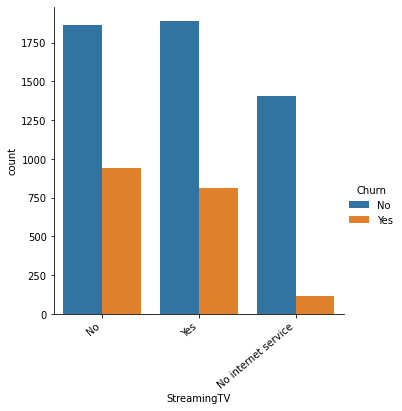

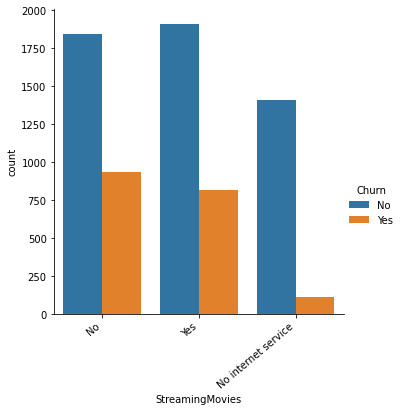

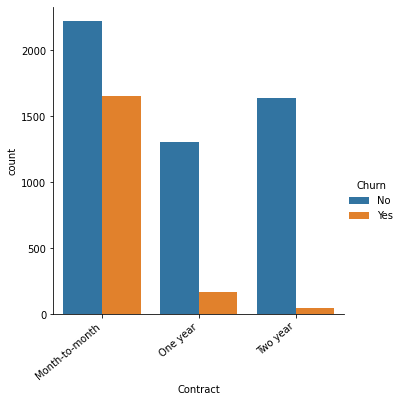

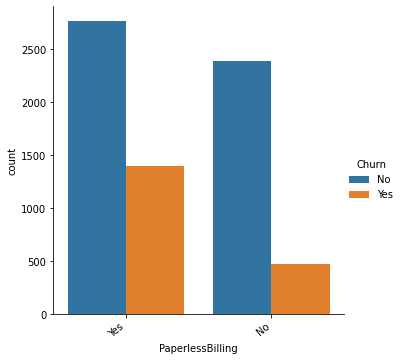

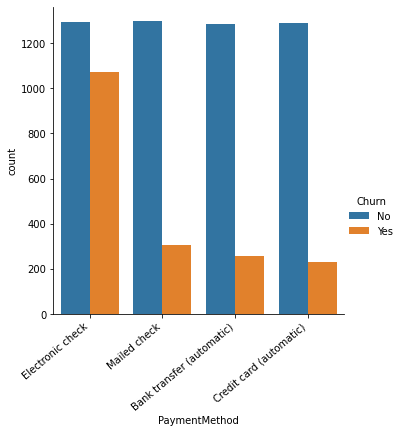

In [9]:
cols = ["gender", "SeniorCitizen", "Partner", "Dependents", 'PhoneService', 'MultipleLines', 'InternetService', 
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'] 

for col in cols:
    plt = sns.catplot(x=col,hue='Churn',data=df,kind="count")
    plt.set_xticklabels(rotation=40, ha="right")

In [10]:
df["Churn"].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [11]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [12]:
train["Churn"] = pd.Series(np.where(train["Churn"].values == 'Yes', 1, 0), train["Churn"].index)

In [13]:
train_X = train.loc[:, train.columns != "Churn"]
train_y = train["Churn"] 

In [14]:
weights = (train_y == 0).sum() / (1.0 * (train_y == 1).sum())

In [15]:
train_X.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [16]:
bin_cols = ["Partner", "Dependents", "PaperlessBilling", "PhoneService"]

def encode_binary(df):
    
    for col in bin_cols:
        df[col] = pd.Series(np.where(df[col].values == 'Yes', 1, 0), df.index)
    
    df["gender"] = pd.Series(np.where(df["gender"].values == 'Male', 1, 0), df.index)
    
    return df

In [17]:
train_X = encode_binary(train_X)

In [18]:
train_X = pd.get_dummies(train_X, columns=['MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaymentMethod'])

In [19]:
test["Churn"] = pd.Series(np.where(test["Churn"].values == 'Yes', 1, 0), test["Churn"].index)

test_X = test.loc[:, test.columns != "Churn"]
test_y = test["Churn"] 

In [20]:
test_X = encode_binary(test_X)

In [21]:
test_X = pd.get_dummies(test_X, columns=['MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaymentMethod'])

In [22]:
model = XGBClassifier(max_depth=9, scale_pos_weight=weights)

In [25]:
probabilities = model.fit(train_X, train_y).predict_proba(test_X)

[13:12:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
probabilities

array([[9.9979806e-01, 2.0196318e-04],
       [9.8524272e-01, 1.4757296e-02],
       [1.6932261e-01, 8.3067739e-01],
       ...,
       [9.9562895e-01, 4.3710684e-03],
       [9.3748522e-01, 6.2514789e-02],
       [9.9997967e-01, 2.0324924e-05]], dtype=float32)

In [27]:
print('AUPRC = {}'.format(average_precision_score(test_y, probabilities[:, 1])))

AUPRC = 0.5980135666862504


In [28]:
# make predictions for test data
y_pred = model.predict_proba(test_X.iloc[:1])
# predictions = [round(value) for value in y_pred]

In [29]:
y_pred

array([[9.9979806e-01, 2.0196318e-04]], dtype=float32)

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
predictions = [np.argmax(prob) for prob in probabilities]

In [32]:
# evaluate predictions
accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.91%


Confusion matrix:
 [[845 188]
 [151 223]]


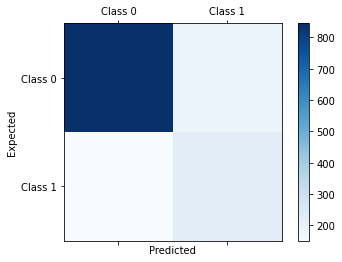

In [35]:
conf_mat = confusion_matrix(y_true=test_y, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

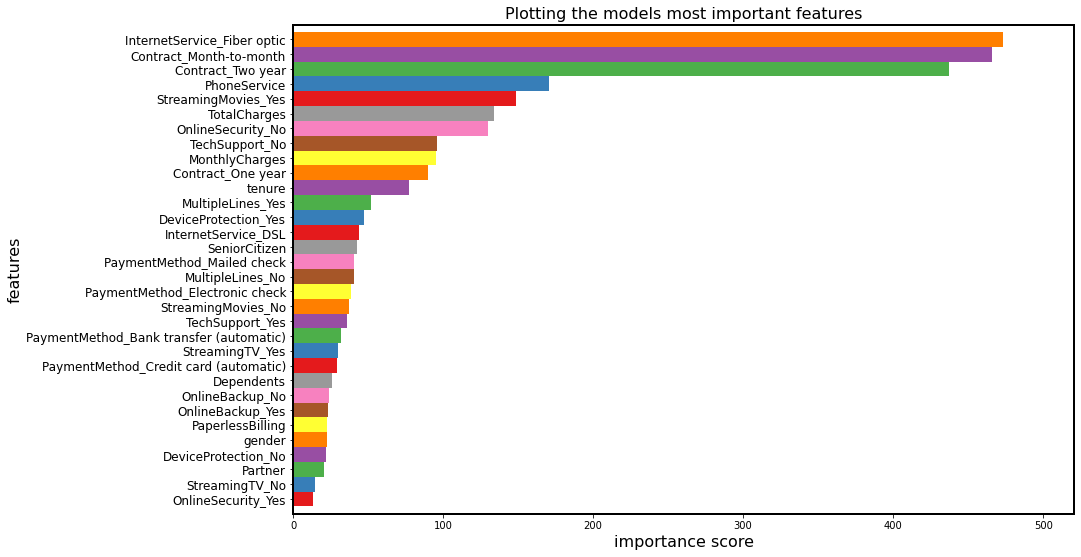

In [36]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(model, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Plotting the models most important features', size = 16);

In [37]:
model.save_model('model.bst')

In [38]:
YOUR_NAME = "spry"

In [39]:
!gsutil cp model.bst gs://kelly-seldon/customer-churn/models/{YOUR_NAME}/model.bst

Copying file://model.bst [Content-Type=application/octet-stream]...
- [1 files][548.8 KiB/548.8 KiB]                                                
Operation completed over 1 objects/548.8 KiB.                                    


## Deploy model using Seldon Deploy SDK

In [40]:
SD_IP = "34.141.146.222"

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = "client_credentials"

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

In [41]:
# MUST BE ALL LOWERCASE WITH NO UNDERSCORES
DEPLOYMENT_NAME = f"{YOUR_NAME}-churn"
MODEL_URI = f"gs://kelly-seldon/customer-churn/models/{YOUR_NAME}"

NAMESPACE = "seldon-gitops"

CPU_REQUESTS = "0.1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "0.1"
MEMORY_LIMITS = "1Gi"

In [42]:
mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE,
        "labels": {
            "fluentd": "true"
        }
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "annotations": {
            "seldon.io/engine-seldon-log-messages-externally": "true"
        },
        "protocol": "seldon",
        "transport": "rest",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{DEPLOYMENT_NAME}-container",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "implementation": "XGBOOST_SERVER",
                    "modelUri": MODEL_URI,
                    "name": f"{DEPLOYMENT_NAME}-container",
                    "endpoint": {
                        "type": "REST"
                    },
                    "parameters": [],
                    "children": [],
                    "logger": {
                        "mode": "all"
                    }
                }
            }
        ]
    },
    "status": {}
}

In [43]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': {'fluentd': 'true'},
              'managed_fields': None,
              'name': 'spry-churn',
              'namespace': 'seldon-gitops',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
          'name': 'spry-churn',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [{'hpa_spec': None,
         

```
{
    "data": {
        "ndarray": [
            [0, 0, 0, 0, 18, 1, 1, 95.05, 1679.4,
            0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 
            0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 
            0, 1, 0, 0, 0]
        ]
    }
}
```

In [44]:
prediction_schema = {
    "requests": [
        {
            "name": "gender",
            "type": "CATEGORICAL",
            "dataType": "INT",
            "nCategories": "2",
            "categoryMap": {
                "0": "Female",
                "1": "Male"
            }
        },
        {
            "name": "SeniorCitizen",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "Partner",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "Dependents",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "tenure",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "PhoneService",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "PaperlessBilling",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "MonthlyCharges",
            "type": "REAL",
            "dataType": "FLOAT"
        },
        {
            "name": "TotalCharges",
            "type": "REAL",
            "dataType": "FLOAT"
        },
        {
            "name": "MultipleLines_No",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "MultipleLines_No phone service",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "MultipleLines_Yes",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "InternetService_DSL",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "InternetService_Fiber optic",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "InternetService_No",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "OnlineSecurity_No",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "OnlineSecurity_No internet service",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "OnlineSecurity_Yes",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "OnlineBackup_No",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "OnlineBackup_No internet service",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "OnlineBackup_Yes",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "DeviceProtection_No",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "DeviceProtection_No internet service",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "DeviceProtection_Yes",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "TechSupport_No",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "TechSupport_No internet service",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "TechSupport_Yes",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "StreamingTV_No",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "StreamingTV_No internet service",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "StreamingTV_Yes",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "StreamingMovies_No",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "StreamingMovies_No internet service",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "StreamingMovies_Yes",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "Contract_Month-to-month",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "Contract_One year",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "Contract_Two year",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "PaymentMethod_Bank transfer (automatic)",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "PaymentMethod_Credit card (automatic)",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "PaymentMethod_Electronic check",
            "type": "REAL",
            "dataType": "INT"
        },
        {
            "name": "PaymentMethod_Mailed check",
            "type": "REAL",
            "dataType": "INT"
        }
    ],
    "responses": [{
        "name": "Likelihood of Churn",
        "type": "REAL",
        "dataType": "FLOAT",
    }]
}

In [47]:
model_catalog_metadata = {
      "URI": MODEL_URI,
      "name": f"{DEPLOYMENT_NAME}-model",
      "version": "v1.0",
      "artifactType": "XGBOOST",
      "taskType": "Customer churn classification",
      "tags": {
        "auto_created": "true",
        "author": f"{YOUR_NAME}"
      },
      "metrics": {},
      "project": "default",
      "prediction_schema": prediction_schema
    }

model_catalog_metadata

{'URI': 'gs://kelly-seldon/customer-churn/models/spry',
 'name': 'spry-churn-model',
 'version': 'v1.0',
 'artifactType': 'XGBOOST',
 'taskType': 'Customer churn classification',
 'tags': {'auto_created': 'true', 'author': 'spry'},
 'metrics': {},
 'project': 'default',
 'prediction_schema': {'requests': [{'name': 'gender',
    'type': 'CATEGORICAL',
    'dataType': 'INT',
    'nCategories': '2',
    'categoryMap': {'0': 'Female', '1': 'Male'}},
   {'name': 'SeniorCitizen', 'type': 'REAL', 'dataType': 'INT'},
   {'name': 'Partner', 'type': 'REAL', 'dataType': 'INT'},
   {'name': 'Dependents', 'type': 'REAL', 'dataType': 'INT'},
   {'name': 'tenure', 'type': 'REAL', 'dataType': 'INT'},
   {'name': 'PhoneService', 'type': 'REAL', 'dataType': 'INT'},
   {'name': 'PaperlessBilling', 'type': 'REAL', 'dataType': 'INT'},
   {'name': 'MonthlyCharges', 'type': 'REAL', 'dataType': 'FLOAT'},
   {'name': 'TotalCharges', 'type': 'REAL', 'dataType': 'FLOAT'},
   {'name': 'MultipleLines_No', 'type': 

In [48]:
metadata_api = ModelMetadataServiceApi(auth())
metadata_api.model_metadata_service_update_model_metadata(model_catalog_metadata)

{}

In [49]:
metadata_response = metadata_api.model_metadata_service_list_model_metadata(uri=MODEL_URI)
metadata_response

{'models': [{'artifact_type': 'XGBOOST',
             'creation_time': datetime.datetime(2022, 8, 4, 10, 49, 8, 137149, tzinfo=tzutc()),
             'metrics': {},
             'name': 'spry-churn-model',
             'prediction_schema': {'requests': [{'category_map': {'0': 'Female',
                                                                  '1': 'Male'},
                                                 'data_type': 'INT',
                                                 'n_categories': '2',
                                                 'name': 'gender',
                                                 'schema': [],
                                                 'shape': [],
                                                 'type': 'CATEGORICAL'},
                                                {'category_map': {},
                                                 'data_type': 'INT',
                                                 'n_categories': '0',
                     

### Create an Explainer

In [50]:
def predict_fn(x):
    return model.predict_proba(x)

In [51]:
columns = list(train_X.columns)
explainer = AnchorTabular(predict_fn, columns)

In [52]:
Xchurn = train_X.loc[train_y == 1]
XnonChurn = train_X.loc[train_y == 0]

In [53]:
balanced_set = pd.concat([Xchurn, XnonChurn.iloc[:len(Xchurn)]]).to_numpy()

In [54]:
explainer.fit(balanced_set, disc_perc=(25, 50, 75)) 

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'disc_perc': (25, 50, 75), 'seed': None},
  'version': '0.6.4'}
)

In [55]:
idx = 36

testX_array = test_X.to_numpy()

class_names = ["Non-Churn", "Churn"]
print('Prediction: ', class_names[explainer.predictor(testX_array[idx].reshape(1, -1))[0]])

np.random.seed(0)

explanation = explainer.explain(testX_array[idx], threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  Non-Churn
Anchor: tenure > 5.00 AND TechSupport_No <= 0.00 AND StreamingTV_Yes <= 0.00 AND PaymentMethod_Bank transfer (automatic) > 0.00 AND TotalCharges > 1127.72 AND PaymentMethod_Electronic check <= 0.00
Precision: 0.97
Coverage: 0.03


In [56]:
explainer.save("explainer-churn")

In [57]:
!gsutil cp -r explainer-churn gs://kelly-seldon/customer-churn/models/{YOUR_NAME}/explainer-churn

Copying file://explainer-churn/explainer.dill [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://explainer-churn/meta.dill [Content-Type=application/octet-stream]...
- [2 files][567.8 MiB/567.8 MiB]   24.0 MiB/s                                   
Operation completed over 2 objects/567.8 MiB.               

### Deploying the Explainer

In [58]:
EXPLAINER_TYPE = "AnchorTabular"
EXPLAINER_URI = f"gs://kelly-seldon/customer-churn/models/{YOUR_NAME}/explainer-churn/"

explainer_spec = {
    "type": EXPLAINER_TYPE,
    "modelUri": EXPLAINER_URI,
    "containerSpec": {
        "name": "",
        "resources": {}
    }
}

In [59]:
mldeployment['spec']['predictors'][0]['explainer'] = explainer_spec

In [60]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': {'fluentd': 'true'},
              'managed_fields': None,
              'name': 'spry-churn',
              'namespace': 'seldon-gitops',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
          'name': 'spry-churn',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [{'hpa_spec': None,
         

In [ ]:
testX_array[idx]

### Call Deployed Explainer

In [61]:
from seldon_deploy_sdk import ExplainApi

In [62]:
explain_api = ExplainApi(auth()) 

In [67]:
namespace = "seldon-gitops"
name = "spry-churn"
explaindata = {
    "data": {
        "ndarray": [
            [0, 0, 0, 0, 18, 1, 1, 95.05, 1679.4,
            0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 
            0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 
            0, 1, 0, 0, 0]
        ]
    }
}

In [68]:
api_response = explain_api.explain_seldon_deployment(namespace, name, explaindata=explaindata)

In [69]:
api_response

{'data': {'anchor': ['PaymentMethod_Mailed check <= 0.00',
   'DeviceProtection_No <= 0.00',
   '0.00 < OnlineSecurity_No <= 1.00',
   '0.00 < OnlineBackup_No <= 1.00',
   '0.00 < InternetService_Fiber optic <= 1.00',
   'Dependents <= 0.00',
   'TechSupport_No internet service <= 0.00',
   '1127.72 < TotalCharges <= 3332.76',
   'InternetService_No <= 0.00',
   'OnlineSecurity_No internet service <= 0.00',
   '5.00 < tenure <= 21.00',
   'PaymentMethod_Electronic check <= 0.00',
   'InternetService_DSL <= 0.00',
   'Contract_Two year <= 0.00',
   '0.00 < TechSupport_Yes <= 1.00',
   'StreamingMovies_No <= 0.00',
   'MonthlyCharges > 91.14',
   'OnlineBackup_No internet service <= 0.00',
   '0.00 < PaperlessBilling <= 1.00',
   'OnlineBackup_Yes <= 0.00',
   'MultipleLines_No <= 0.00',
   'OnlineSecurity_Yes <= 0.00',
   '0.00 < MultipleLines_Yes <= 1.00',
   'gender <= 0.00',
   'Contract_One year <= 0.00',
   'Partner <= 0.00',
   'StreamingTV_Yes <= 0.00',
   '0.00 < Contract_Month-